In [52]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img
from nilearn import image
from nilearn import plotting
import argparse
from nilearn.image import new_img_like
import matplotlib.pyplot as plt


In [2]:
# load group data
beta_dir =  '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/deriv05_singletrialnpy'
suballLv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_event-stimulus_cuetype-low.npy"))
suballHv = np.load(os.path.join(beta_dir, f"sub-avg_ses-avg_run-avg_event-stimulus_cuetype-high.npy"))

In [3]:
suballLv.shape # 111 participants, (73, 86, 73) brain shape

(111, 458294)

In [4]:
# create mask from canlab mask. Use sample single trial as target shape/affine
imgfname = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
ref_img = image.load_img(imgfname)

mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = ref_img.affine, target_shape = ref_img.shape, 
                    memory="nilearn_cache", memory_level=1)

In [5]:
# apply mask to each average numpy (shape: subjects x voxels)
        
x,y,z=ref_img.shape
H = []
L = []
for index in range(111):

    H.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballHv[index].reshape(x,y,z)))
    )
    L.append(
        nifti_masker.fit_transform(
    new_img_like(ref_img, suballLv[index].reshape(x,y,z)))
    )

In [6]:
fmri_masked_stimhigh = np.vstack(H)
fmri_masked_stimlow = np.vstack(L)
print(fmri_masked_stimlow.shape)

(111, 98053)


In [53]:
# t-test and FDR multiple comparisons
contrast = scipy.stats.ttest_rel(fmri_masked_stimhigh,fmri_masked_stimlow,
                                     axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, pvals_corrected, _, alphacBonf = multitest.multipletests(contrast.pvalue, alpha = 0.001, method = 'fdr_bh')

# correct odd p values
contrast.pvalue[np.isnan(contrast.pvalue)] = 1
contrast.pvalue[contrast.pvalue > 1] = 1


In [24]:
contrast.statistic[np.where(contrast.pvalue < alphacBonf)].shape

(40308,)

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


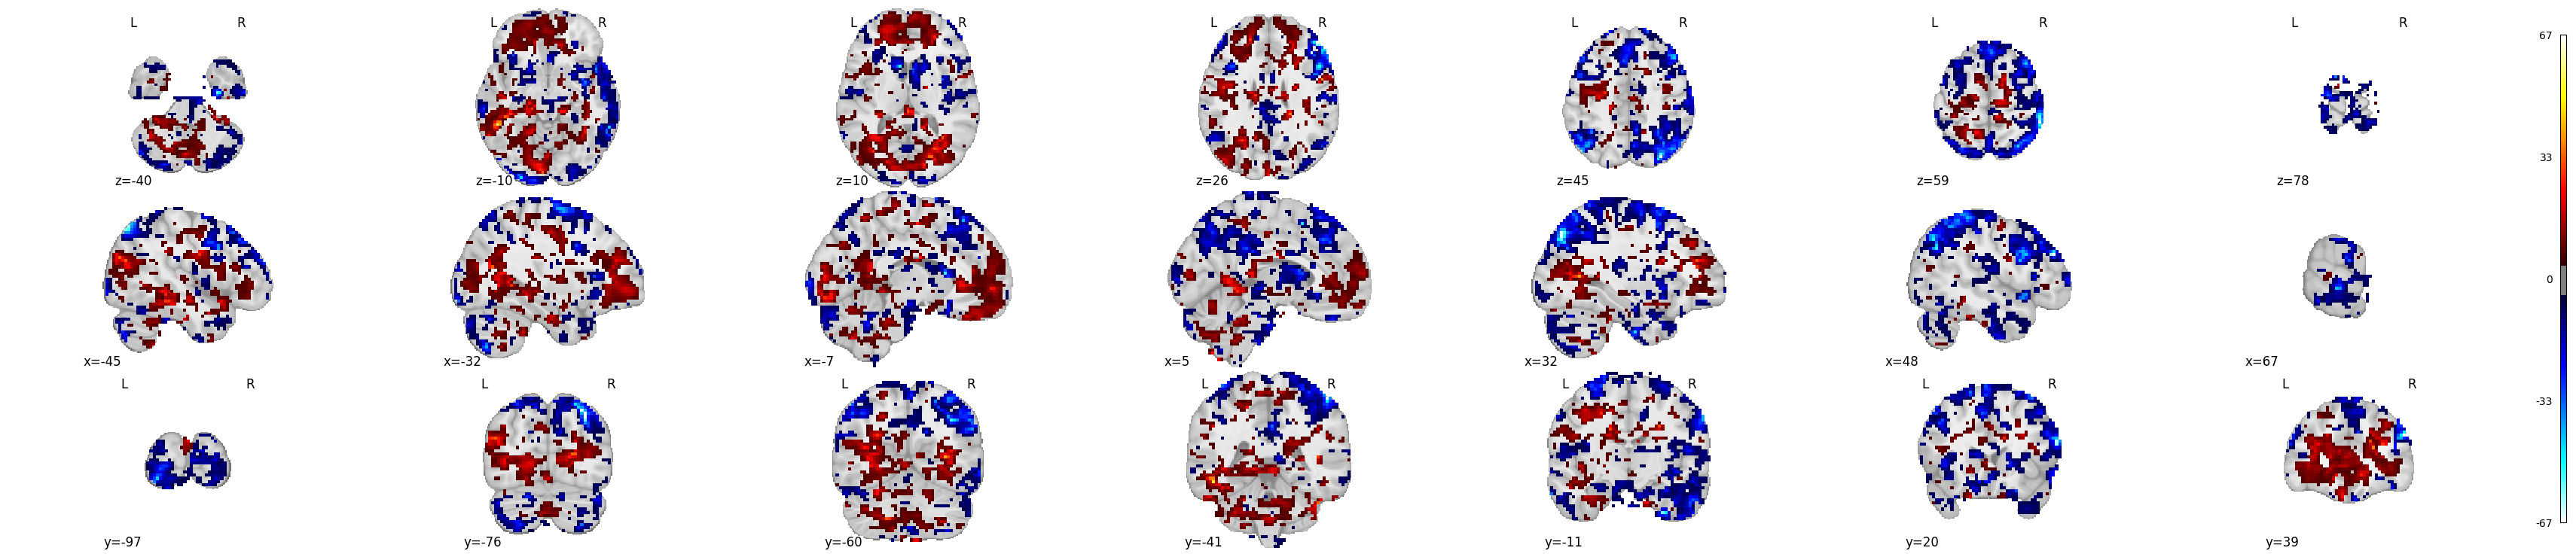

In [57]:
contrast = scipy.stats.ttest_rel(fmri_masked_stimhigh, fmri_masked_stimlow,
                                     axis = 0, nan_policy = 'propagate',alternative='two-sided' )
reject, pvals_corrected, _, alphacBonf = multitest.multipletests(contrast.pvalue, alpha = 0.001, method = 'fdr_bh')
tvals_filtered = np.where(contrast.pvalue < alphacBonf, contrast.statistic, np.nan)
con_tmap = nifti_masker.inverse_transform(tvals_filtered)
# QUESTION: which threshold to use?
threshold=4
plotting.plot_stat_map(con_tmap, threshold = threshold, display_mode = 'mosaic')